# 진짜 데이터 진짜 딥러닝 모델 만들기 - LSTM

In [129]:
# 필요한 라이브러리 가져오기
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from tensorflow.keras.models import save_model, load_model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import ADASYN, SMOTE
import tensorflowjs as tfjs
import matplotlib.pyplot as plt

In [156]:
max_len = 0
# input 데이터 열기
with open('GameData/input_0516.txt', 'r') as file:
    for line in file:
        row = line.strip().split(',')
        row_len = len(row)
        if row_len > max_len:
            max_len = row_len
            
df = pd.read_table('GameData/input_0516.txt', delimiter=',', header=None, names=range(max_len))
rdf = pd.read_table('GameData/output_0516.txt', delimiter=',', header=None)

# 추가할 데이터가 있으면 이런 방식으로해도 됨
# df2 = pd.read_table('GameData/input_0509_2.txt', delimiter=',', header=None, names=range(max_len))
# rdf2 = pd.read_table('GameData/output_0509_2.txt', delimiter=',', header=None)

# df = pd.concat([df1, df2])
# rdf = pd.concat([rdf1, rdf2])

print(rdf[0].value_counts())
df


0
0    2448
1    1037
2     221
Name: count, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091
0,-11544.458268,1285.945203,100.0,1.0,-12030.954249,-1859.386670,100.0,1.0,-12535.313778,1439.890427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-11614.216075,2544.731581,100.0,1.0,-12594.218842,1940.486917,100.0,1.0,-12379.601587,6233.180445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-11647.007098,6928.449868,100.0,1.0,-10651.121763,3092.797568,100.0,1.0,-12146.759739,6747.732429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-10712.886244,592.659195,100.0,1.0,-11312.545314,3079.750318,100.0,1.0,-11455.866468,-529.831664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-12053.004608,5507.176078,100.0,1.0,-12139.508699,4340.605687,100.0,1.0,-11865.697675,5915.205405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,-11152.817174,802.982136,100.0,1.0,-11700.672407,2618.631099,100.0,1.0,-11633.441573,2908.004337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3702,-12636.879852,5047.498982,100.0,1.0,-12095.314050,5489.536600,100.0,1.0,-11691.360337,5999.294925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3703,-12770.308854,2169.730766,100.0,1.0,-10868.276461,-2671.473881,100.0,1.0,-11003.547286,6434.045137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3704,-10883.372621,177.636460,100.0,1.0,-11101.932132,-287.746542,100.0,1.0,-11330.668815,154.698653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 데이터 전처리

In [157]:
# 데이터 정규화
df = df.fillna(0)
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

df

array([[0.57248114, 0.39201782, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.55769726, 0.50985584, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.55074781, 0.92022627, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.31268467, 0.47475111, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.71258608, 0.28826636, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.44978384, 0.32110597, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [158]:
games = rdf.shape[0]
features_dim = 66 # [x, y좌표, 체력, 교전여부] -> 4*16 = 64, 각 팀별 스코어 2  -> 66
timesteps = max_len // features_dim 

features = df.reshape(games, timesteps, features_dim)
labels = rdf.values 

print(features.shape)
print(labels.shape)

(3706, 62, 66)
(3706, 1)


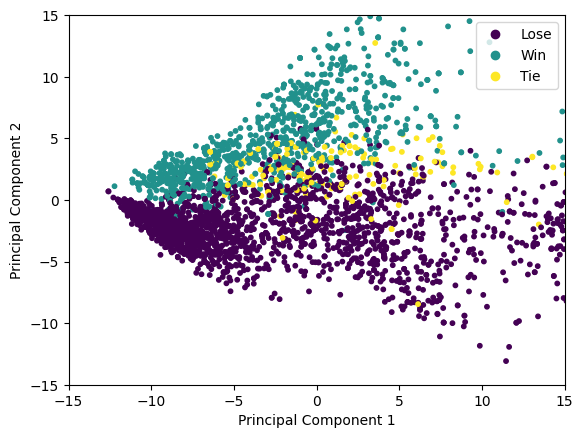

In [159]:
# 오버샘플링 이전 데이터
# 전체 피쳐를 2차원으로 축소
flattened_features = features.reshape(games, -1)  # 3차원 데이터를 2차원으로 펼침
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(flattened_features)


# 산점도 분포 그리기
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels.flatten(), cmap='viridis', s=10)

# 범례 설정
legend_labels = ['Lose', 'Win', 'Tie']  # 각 클래스에 대한 레이블
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right')

# 축 라벨 설정
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.ylim(-15, 15)
plt.xlim(-15, 15)

# 그래프 출력
plt.savefig('0518_before_oversampling.png')
plt.show()

In [160]:
# ADASYN 오버샘플링 적용
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(df, rdf)

# 결과 확인
print("Original dataset shape:", df.shape, rdf.shape)
print("Resampled dataset shape:", X_resampled.shape, y_resampled.shape)
print(y_resampled[0].value_counts())

games = y_resampled.shape[0]
features_dim = 66
timesteps = max_len // features_dim 

features = X_resampled.reshape(games, timesteps, features_dim)
labels = y_resampled.values 

print(features.shape)
print(labels.shape)

Original dataset shape: (3706, 4092) (3706, 1)
Resampled dataset shape: (7337, 4092) (7337, 1)
0
0    2448
1    2445
2    2444
Name: count, dtype: int64
(7337, 62, 66)
(7337, 1)


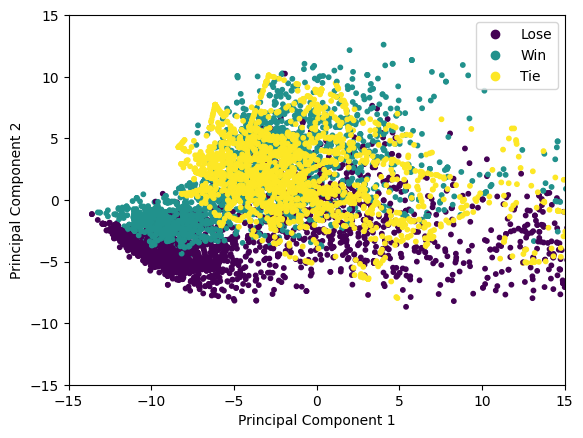

In [161]:
# ADASYN
# 오버샘플링 이후 데이터
# 전체 피쳐를 2차원으로 축소
flattened_features = features.reshape(games, -1)  # 3차원 데이터를 2차원으로 펼침
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(flattened_features)


# 산점도 분포 그리기
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels.flatten(), cmap='viridis', s=10)

# 범례 설정
legend_labels = ['Lose', 'Win', 'Tie']  # 각 클래스에 대한 레이블
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right')

# 축 라벨 설정
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.ylim(-15, 15)
plt.xlim(-15, 15)

# 그래프 출력
plt.savefig('0518_ADASYN_oversampling.png')
plt.show()

In [162]:
# SMOTE 오버샘플링 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df,rdf)

# 결과 확인
print("Original dataset shape:", df.shape, rdf.shape)
print("Resampled dataset shape:", X_resampled.shape, y_resampled.shape)
print(y_resampled[0].value_counts())

games = y_resampled.shape[0]
features_dim = 66
timesteps = max_len // features_dim 

features = X_resampled.reshape(games, timesteps, features_dim)
labels = y_resampled.values 

print(features.shape)
print(labels.shape)

Original dataset shape: (3706, 4092) (3706, 1)
Resampled dataset shape: (7344, 4092) (7344, 1)
0
0    2448
1    2448
2    2448
Name: count, dtype: int64
(7344, 62, 66)
(7344, 1)


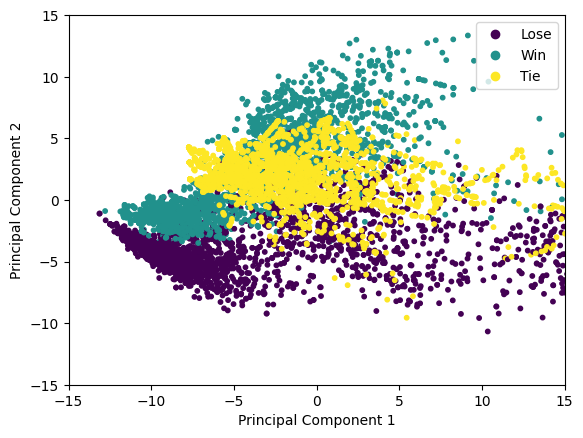

In [163]:
# SMOTE
# 오버샘플링 이후 데이터
# 전체 피쳐를 2차원으로 축소
flattened_features = features.reshape(games, -1)  # 3차원 데이터를 2차원으로 펼침
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(flattened_features)

# 산점도 분포 그리기
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels.flatten(), cmap='viridis', s=10)

# 범례 설정
legend_labels = ['Lose', 'Win', 'Tie']  # 각 클래스에 대한 레이블
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right')

# 축 라벨 설정
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.ylim(-15, 15)
plt.xlim(-15, 15)

# 그래프 출력
plt.savefig('0518_SMOTE_oversampling.png')
plt.show()

In [164]:
# 데이터셋 나누기
train_X, test_X, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=42)
print(train_X.shape)

(5875, 62, 66)


## 딥러닝 모델

### LSTM모델 생성

In [165]:
# LSTM 모델 생성 함수
layer1 = 128
layer2 = 16
layer3 = 8


def f1(train_y, test_y):
    """
    F1 score 계산을 위한 함수
    """
    true_positives = K.sum(K.round(K.clip(train_y * test_y, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(test_y, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(train_y, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def create_model():
    model = Sequential()
    model.add(LSTM(layer1, return_sequences=True, kernel_initializer=initializers.glorot_uniform(), input_shape=(None, features_dim)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(layer2, return_sequences=True, kernel_initializer=initializers.glorot_uniform())))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(layer3, kernel_initializer=initializers.glorot_uniform()) ))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_initializer=initializers.glorot_uniform()))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[f1, 'accuracy'])
    return model

# 모델 생성
model = create_model()

# 조기 종료
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 학습
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=100, batch_size=64, callbacks = [early_stopping])

save_model(model, '/home/j-k8e202/test_kyj/0518_1_LSTM_model.h5')
tfjs.converters.save_keras_model(model, "/home/j-k8e202/test_kyj/0518_1_LSTM_model")


Epoch 1/100
92/92 [==============================] - 10s 34ms/step - loss: 0.6032 - f1: 1.1234 - accuracy: 0.7637 - val_loss: 0.5011 - val_f1: 0.9938 - val_accuracy: 0.8952
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.2794 - f1: 0.8616 - accuracy: 0.9134 - val_loss: 0.4412 - val_f1: 0.8829 - val_accuracy: 0.8639
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.1894 - f1: 0.8372 - accuracy: 0.9416 - val_loss: 0.4158 - val_f1: 0.8804 - val_accuracy: 0.8366
Epoch 4/100
92/92 [==============================] - 2s 18ms/step - loss: 0.1387 - f1: 0.8220 - accuracy: 0.9597 - val_loss: 0.1274 - val_f1: 0.8351 - val_accuracy: 0.9646
Epoch 5/100
92/92 [==============================] - 2s 20ms/step - loss: 0.1181 - f1: 0.8217 - accuracy: 0.9661 - val_loss: 0.2940 - val_f1: 0.8629 - val_accuracy: 0.8952
Epoch 6/100
92/92 [==============================] - 2s 18ms/step - loss: 0.0783 - f1: 0.8136 - accuracy: 0.9767 - val_loss: 0.1024 - val_f

## 게임 중간까지의 데이터를 줄 때, 승률 예측이 잘 되나?

In [148]:
# 예측할 게임 중간 데이터
mid_game_data = test_X[:3, :3, :] 

# 예측 수행
prediction = model.predict(mid_game_data)
print("예측된 클래스 확률:", prediction)

1/1 [==============================] - 0s 26ms/step
예측된 클래스 확률: [[0.13888901 0.02981739 0.8312935 ]
 [0.1842632  0.04134836 0.7743885 ]
 [0.21523492 0.05198512 0.7327799 ]]


In [149]:
# 모델 예측
pred_df = pd.read_table('GameData/input_0517_only.txt', delimiter=',', header=None, names=range(max_len))
pred_rdf = pd.read_table('GameData/output_0517_only.txt', delimiter=',', header=None)

# 데이터 정규화
pred_df = pred_df.fillna(0)
scaler = MinMaxScaler()
pred_df = scaler.fit_transform(pred_df)

games = pred_rdf.shape[0]
features_dim = 66 # [x, y좌표, 체력, 교전여부] -> 4*16 = 64, 각 팀별 스코어 2  -> 66
timesteps = max_len // features_dim 

features = pred_df.reshape(games, timesteps, features_dim)
labels = pred_rdf.values 

pred_prob = model.predict(features)

# 확률을 클래스 레이블로 변환
pred_labels = np.argmax(pred_prob, axis=1)

print(labels)
print(pred_labels)

# F1 스코어 계산
f1sc = f1_score(pred_rdf, pred_labels, average='macro')
print("F1 score: %.4f" % f1sc)

11/11 [==============================] - 0s 6ms/step
[[0]
 [0]
 [0]
 [2]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [2]
 [0]
 [1]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [1]
 [2]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [2]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [2]
 [0]
 [1]
 [0]
 [2]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [2]
 [0]
 [0]
 [2]
 [2]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [2]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [

# 저장한 모델을 불러와서 사용하기

In [150]:
# 저장된 모델 불러오기
# loaded_model = load_model('test_kyj/0517_5_LSTM_model.h5')

# 일단은 현재 학습한 모델을 바로 사용
loaded_model = model

# 모델 구조 및 파라미터 확인
print(loaded_model.summary())

df = pd.read_table('GameData/input_0517_only.txt', delimiter=',', header=None, names=range(max_len))
rdf = pd.read_table('GameData/output_0517_only.txt', delimiter=',', header=None)

# 데이터 정규화
df = df.fillna(0)
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

games = rdf.shape[0]
features_dim = 66 # [x, y좌표, 체력, 교전여부] -> 4*16 = 64, 각 팀별 스코어 2  -> 66
timesteps = max_len // features_dim 

features = df.reshape(games, timesteps, features_dim)
labels = rdf.values 
pred_y = loaded_model.predict(features)

pred = []
tmp = 0
for i in pred_y :
    if i[0] > i[1] and i[0] > i[2] :
        tmp = 0
    elif i[1] > i[0] and i[1] > i[2] :
        tmp = 1
    elif i[2] > i[0] and i[2] > i[1] :
        tmp = 2
    pred.append([tmp])
    
print(classification_report(labels, pred))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, None, 128)         99840     
                                                                 
 dropout_15 (Dropout)        (None, None, 128)         0         
                                                                 
 batch_normalization_10 (Bat  (None, None, 128)        512       
 chNormalization)                                                
                                                                 
 bidirectional_10 (Bidirecti  (None, None, 32)         18560     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, None, 32)          0         
                                                                 
 batch_normalization_11 (Bat  (None, None, 32)        

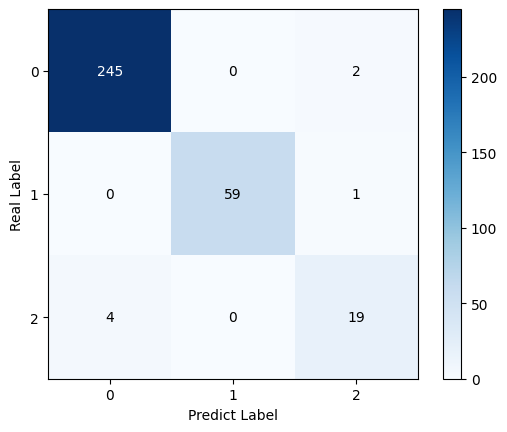

0.9787878787878788


In [152]:
# 삼항 혼동 행렬 계산
cm = confusion_matrix(labels, pred)

# 혼동 행렬 그리기
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, [0, 1, 2])
plt.yticks(tick_marks, [0, 1, 2])

# 혼동 행렬의 값 표시
thresh = cm.max() / 2.
for i in range(3):
    for j in range(3):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predict Label')
plt.ylabel('Real Label')
plt.savefig('0518_1_oversampling_LSTM_model_.png')
plt.show()

print(accuracy_score(labels, pred))

230/230 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2448
           1       1.00      0.99      1.00      2448
           2       1.00      1.00      1.00      2448

    accuracy                           1.00      7344
   macro avg       1.00      1.00      1.00      7344
weighted avg       1.00      1.00      1.00      7344



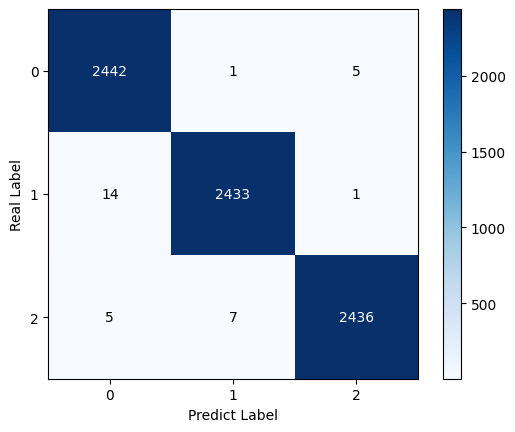

0.9955065359477124


In [126]:
# 오버샘플링 데이터로 confusion matrix
games = y_resampled.shape[0]
features = X_resampled.reshape(games, timesteps, features_dim)
labels = y_resampled.values 
pred_y = loaded_model.predict(features)

pred = []
tmp = 0
for i in pred_y :
    if i[0] > i[1] and i[0] > i[2] :
        tmp = 0
    elif i[1] > i[0] and i[1] > i[2] :
        tmp = 1
    elif i[2] > i[0] and i[2] > i[1] :
        tmp = 2
    pred.append([tmp])
    
print(classification_report(labels, pred))


cm = confusion_matrix(labels, pred)

# 혼동 행렬 그리기
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, [0, 1, 2])
plt.yticks(tick_marks, [0, 1, 2])

# 혼동 행렬의 값 표시
thresh = cm.max() / 2.
for i in range(3):
    for j in range(3):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predict Label')
plt.ylabel('Real Label')
plt.savefig('0518_1_oversampling_LSTM_model_confusion_matrix.png')
plt.show()

print(accuracy_score(labels, pred))

In [81]:
history.history

{'loss': [0.49397706985473633,
  0.22294412553310394,
  0.14270690083503723,
  0.11097784340381622,
  0.1095709577202797,
  0.07565047591924667,
  0.0638391450047493,
  0.05933820828795433,
  0.05104575306177139,
  0.0417204275727272,
  0.04707637056708336,
  0.05100981891155243,
  0.028936438262462616,
  0.05338030308485031,
  0.028164979070425034,
  0.022490590810775757,
  0.030476385727524757,
  0.02354242280125618,
  0.026166904717683792,
  0.037796325981616974,
  0.01699301414191723,
  0.022068409249186516,
  0.014572818763554096,
  0.0178182702511549,
  0.030450617894530296,
  0.02520863711833954,
  0.019940203055739403,
  0.01023449469357729,
  0.02177029848098755,
  0.020655522122979164,
  0.017245879396796227,
  0.017474133521318436,
  0.014206251129508018,
  0.006938999984413385,
  0.0063156550750136375,
  0.020036358386278152,
  0.02013406716287136,
  0.015958011150360107,
  0.019975431263446808,
  0.008433782495558262,
  0.02580498345196247,
  0.009621283039450645,
  0.0116

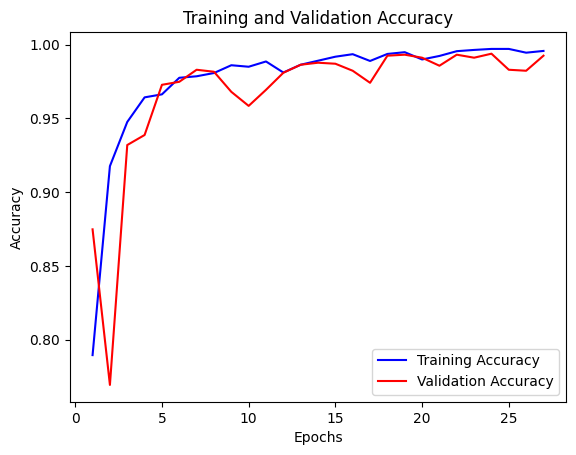

In [153]:
# 학습률, 손실 그래프 그리기
# 학습 과정에서 손실 함수, f1 score, 검증 손실 함수, 검증 f1 score의 변화 추출
loss = history.history['loss']
val_loss = history.history['val_loss']
scoreF1 = history.history['f1']
val_scoreF1 = history.history['val_f1']

# 정확도 계산
accuracy = [acc for acc in history.history.keys() if 'accuracy' in acc]
val_accuracy = [acc for acc in history.history.keys() if 'val_accuracy' in acc]

# 학습률 그래프 그리기
epochs = range(1, len(loss) + 1)

plt.plot(epochs, history.history[accuracy[0]], 'b', label='Training Accuracy')
plt.plot(epochs, history.history[val_accuracy[0]], 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('0518_1_Training_Validation_Accuracy.png')
plt.show()

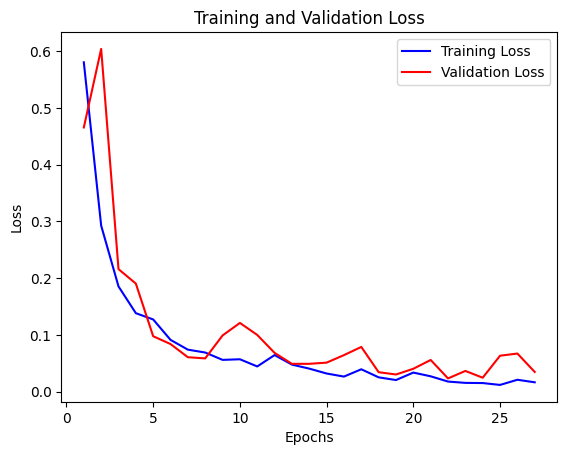

In [154]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('0518_1_Training_Validation_Loss.png')
plt.show()

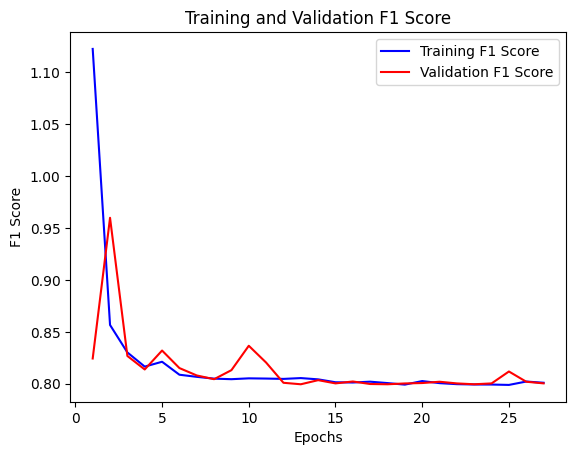

In [155]:
plt.plot(epochs, scoreF1, 'b', label='Training F1 Score')
plt.plot(epochs, val_scoreF1, 'r', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.savefig('0518_1_Training_Validation_F1Score.png')
plt.show()